In [ ]:
## Note: this notebook didnt work, but collab did - https://colab.research.google.com/drive/1JdcCzBFfC83v8LYY_gTAUDaCfoLdJUaT#scrollTo=pyrTt1bNEYGm

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
img = io.read_image('images/puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1330, 1920])


tensor([[[225, 225, 225, 225],
         [225, 225, 225, 225],
         [225, 225, 225, 225]],

        [[228, 228, 228, 228],
         [228, 228, 228, 228],
         [228, 228, 228, 228]]], dtype=torch.uint8)

In [3]:

def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 216, 32400)

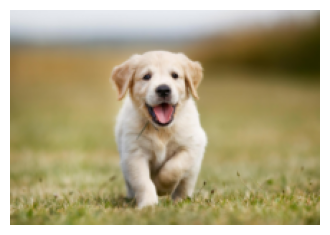

In [5]:
show_img(img2)

### RGB to Gray

#### Basic Python

In [7]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

In [8]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 1.14 s, sys: 2.89 ms, total: 1.14 s
Wall time: 1.14 s


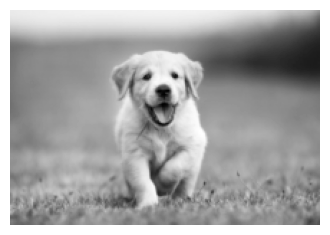

In [9]:
show_img(img_g, cmap='gray')

#### Python Kernel

In [13]:
def run_kernel(f, times, *args):
    for i in range(times): f(i, *args)

NB: A kernel doesnt return anything but transforms the contents that is passed to it

In [10]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [11]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

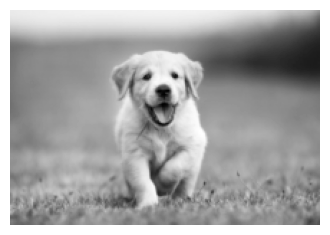

In [14]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

### Python Block Kernel


In [19]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): f(i, j, threads, *args)

In [23]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n, verbose=True):
    i = blockidx*blockdim + threadidx
    if i<n: 
        red, green, blue = x[i], x[i+n], x[i+2*n]
        out[i] = 0.2989*red + 0.5870*green + 0.1140*blue
        if verbose: print(f"Pixel i: {i}, blockidx: {blockidx}, blockdim: {blockdim}, threadidx: {threadidx}, n: {n}, 0.2989 * {green} + 0.5870 * {red} + 0.1140 * {blue} = {out[i]}")

In [24]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

Pixel i: 0, blockidx: 0, blockdim: 256, threadidx: 0, n: 32400, 0.2989 * 228 + 0.5870 * 225 + 0.1140 * 233 = 227
Pixel i: 1, blockidx: 0, blockdim: 256, threadidx: 1, n: 32400, 0.2989 * 228 + 0.5870 * 225 + 0.1140 * 233 = 227
Pixel i: 2, blockidx: 0, blockdim: 256, threadidx: 2, n: 32400, 0.2989 * 228 + 0.5870 * 225 + 0.1140 * 233 = 227
Pixel i: 3, blockidx: 0, blockdim: 256, threadidx: 3, n: 32400, 0.2989 * 229 + 0.5870 * 226 + 0.1140 * 234 = 228
Pixel i: 4, blockidx: 0, blockdim: 256, threadidx: 4, n: 32400, 0.2989 * 229 + 0.5870 * 226 + 0.1140 * 234 = 228
Pixel i: 5, blockidx: 0, blockdim: 256, threadidx: 5, n: 32400, 0.2989 * 229 + 0.5870 * 226 + 0.1140 * 234 = 228
Pixel i: 6, blockidx: 0, blockdim: 256, threadidx: 6, n: 32400, 0.2989 * 229 + 0.5870 * 226 + 0.1140 * 234 = 228
Pixel i: 7, blockidx: 0, blockdim: 256, threadidx: 7, n: 32400, 0.2989 * 229 + 0.5870 * 226 + 0.1140 * 234 = 228
Pixel i: 8, blockidx: 0, blockdim: 256, threadidx: 8, n: 32400, 0.2989 * 230 + 0.5870 * 227 + 0.

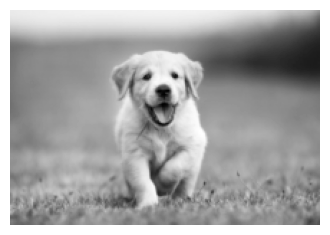

In [25]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

### CUDA Setup

In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [4]:
%load_ext wurlitzer

In [5]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [6]:
cuda_begin = r'''
#include 
#include 
#include 

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA kernel


 * 2^31 max blocks for dim 0, 2^16 max for dims 1 & 2
 * 1024 max threads per block (use a multiple of 32)

In [7]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i>>(
        input.data_ptr(), output.data_ptr(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [8]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [9]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], True, verbose=True)

Using /home/cerebrum/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/cerebrum/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /home/cerebrum/anaconda3/envs/cudalab/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/cerebrum/anaconda3/envs/cudalab/lib/python3.10/site-packages/torch/include -isystem /home/cerebrum/anaconda3/envs/cudalab/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/cerebrum/anaconda3/envs/cudalab/lib/python3.10/site-packages/torch/include/TH -isystem /home/cerebrum/anaconda3/envs/cudalab/lib/python3.10/site-packages/torch/include/THC -isystem /home/cerebrum/anaconda3/envs/cudalab/include -isystem /home/cerebrum/anaconda3/envs/cudalab/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=comp

RuntimeError: Error building extension 'inline_ext'